In [223]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score,auc,classification_report,confusion_matrix,roc_curve,roc_auc_score,recall_score

from sklearn.compose import ColumnTransformer


from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline 
#
# from imblearn.over_sampling import SMOTE

import joblib

In [224]:
df = pd.read_csv(r"../data/raw/data.csv")

In [225]:
df.head(15)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [226]:
df[["Loan_Amount_Term","Loan_ID"]].groupby(by=["Loan_Amount_Term"]).count().sort_values(by=["Loan_ID"])

,Loan_ID
Loan_Amount_Term,
12.0,1
36.0,2
60.0,2
120.0,3
84.0,4
240.0,4
300.0,13
480.0,15
180.0,44


In [227]:
cat_columns = ['Self_Employed',
 'Dependents',
 'Gender',
 'Married',
 'Education',
 'Property_Area',
 'Credit_History']

num_columns = ['LoanAmount','ApplicantIncome','TotalApplicantIncome']

In [228]:
class PipeCustomOrdinalEncoder(BaseEstimator,TransformerMixin):
    '''
    Converts categories into numbers for KNNImputing
    '''
    
    def __init__(self):
        self.ord_encoder = OrdinalEncoder()
#         self.feature = feature_name
    
    def fit(self,X,y=None):
        na_indices = X[X.isna()].index.values
        not_na_rows = X[X.notna()]
        not_na_np = not_na_rows.to_numpy().reshape(-1,1)
        self.ord_encoder = self.ord_encoder.fit(not_na_np)
        return self
    
    def transform(self,X,y=None):
        na_indices = X[X.isna()].index.values
        not_na_rows = X[X.notna()]
        not_na_np = not_na_rows.to_numpy().reshape(-1,1)
        transformed_data = self.ord_encoder.transform(not_na_np)
        not_na_encode = pd.Series(transformed_data.flatten(),index = not_na_rows.index.values)
        return pd.DataFrame(pd.concat([not_na_encode,X[X.isna()]]).sort_index())
    
    def inverse_transform(self,X,y=None):
        col = X.to_numpy().reshape(-1,1)
        return self.ord_encoder.inverse_transform(col)

In [249]:
class CustomKNNImputer(BaseEstimator,TransformerMixin):
    
    def __init__(self,n_neighbors):
        self.n_neighbors = n_neighbors
        self.imputer = KNNImputer(n_neighbors=self.n_neighbors)
    
    def fit(self,X,y=None):
        self.imputer = self.imputer.fit(X)
        return self.imputer 
    
    def transform(self,X,y=None):
        return pd.DataFrame(self.imputer.transform(X),columns=X.columns)
    
    def fit_transform(self,X,y=None):
        self.imputer = self.imputer.fit(X)
        return self.transform(X,y)
    

In [250]:
def return_df(x,cols=None):
    return pd.DataFrame(x,columns=cols)

In [251]:
def transform_dataset(data):
    data.loc[:,"LoanAmount"] = np.log(data.LoanAmount)
    data.loc[:,"TotalApplicantIncome"] = np.log(data.ApplicantIncome+data.CoapplicantIncome)
    data.loc[:,"ApplicantIncome"] = np.log(data.ApplicantIncome)
    data = data.drop(columns=['CoapplicantIncome','Loan_ID','Loan_Amount_Term'])
    return data

In [252]:
# class custom_smote(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.smt = SMOTE(k_neighbors=5)
    
#     def fit(self,X,y=None):
#         self.smt = self.smt.fit(X,y)
#         return self
    
#     def transform(self,X,y=None):
#         x,_ = self.smt.fit_resample(X,y)
#         return x
    

## Pipelines

In [253]:
transformations = FunctionTransformer(transform_dataset)

In [254]:
cat_preprocess = ColumnTransformer(transformers=[
    ('employed',PipeCustomOrdinalEncoder(),'Self_Employed'),
    ('dependents',PipeCustomOrdinalEncoder(),'Dependents'),
    ('married',PipeCustomOrdinalEncoder(),'Married'),
    ('gender',PipeCustomOrdinalEncoder(),'Gender'),
    ('education',PipeCustomOrdinalEncoder(),'Education'),
    ('property',PipeCustomOrdinalEncoder(),'Property_Area'),
    ('credit-history',PipeCustomOrdinalEncoder(),'Credit_History')
                                                ])

categories = Pipeline(steps=[
    ('cat',cat_preprocess),
    ('cat_names',FunctionTransformer(return_df,kw_args={"cols":cat_columns}))
])

In [255]:
num_preprocess = ColumnTransformer(
transformers=[
    ('num_scaling',MinMaxScaler(),num_columns)
])

numerical = Pipeline(steps=[
    ('num',num_preprocess),
    ('num_names',FunctionTransformer(return_df,kw_args={"cols":num_columns}))
])

In [256]:
impute_preprocess = Pipeline(steps=[
    ('transformations',transformations),
    ('feature_union',FeatureUnion(transformer_list=[
        ('cat_pipe',categories),
        ('num_pipe',numerical)
    ])),
    ('test',FunctionTransformer(return_df,kw_args={"cols":cat_columns+num_columns})),
    ('imputer',CustomKNNImputer(n_neighbors=1,))
])

In [257]:
one_hot_encoding_preprocess = FeatureUnion(transformer_list=[
        ('cat_features',ColumnTransformer(
            transformers=[('categorical',OneHotEncoder(),cat_columns),]
        )),
        ('num_features',ColumnTransformer(
            transformers=[('numeric','passthrough',num_columns),]
        ))
    ])

In [258]:
preprocessing = Pipeline(steps=[
    ('impute',impute_preprocess),
    ('one_hot_encoded',one_hot_encoding_preprocess)
])

In [268]:
pipe = Pipeline(steps=[
    ('preprocess',preprocessing),
#     ('smote',custom_smote()),
    ('model',LogisticRegression(random_state=123,fit_intercept=True,max_iter=1000))
],verbose=True)

## Modelling

In [269]:
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

In [270]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=df['Loan_Status'],random_state=60,train_size=0.6)

In [271]:
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

In [272]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [273]:
# X_train_1 = preprocessing.fit_transform(X_train)
# X_test_1 = preprocessing.transform(X_test)

In [274]:
# clf = LogisticRegression(random_state=123,fit_intercept=True,max_iter=1000)

In [275]:
params = {}

In [276]:
model = GridSearchCV(pipe,param_grid=params)
model = model.fit(X_train,y_train)

C:\Users\rvams\.virtualenvs\loan_application\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\rvams\.virtualenvs\loan_application\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\rvams\.virtualenvs\loan_application\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


C:\Users\rvams\.virtualenvs\loan_application\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\rvams\.virtualenvs\loan_application\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\rvams\.virtualenvs\loan_application\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


In [278]:
f1_score(y_train,model.predict(X_train))

0.861646234676007

In [279]:
f1_score(y_test,model.predict(X_test))

0.8693333333333333

In [24]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.32      0.48        77
           1       0.76      0.99      0.86       169

    accuracy                           0.78       246
   macro avg       0.84      0.66      0.67       246
weighted avg       0.81      0.78      0.74       246



In [25]:
print(confusion_matrix(y_test,model.predict(X_test)))

[[ 23  54]
 [  2 167]]


In [ ]:
X_test

In [26]:
X_test[~np.where(model.predict(X_test)==1,True,False)]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalApplicantIncome
22,LP001047,Male,Yes,0,Not Graduate,No,-0.323276,1911.0,-0.811975,360.0,0.0,Semiurban,7.555761
48,LP001146,Female,Yes,0,Graduate,No,-0.321817,3440.0,-0.801782,360.0,0.0,Urban,8.143437
66,LP001228,Male,No,0,Not Graduate,No,-0.306072,2254.0,-0.787496,180.0,0.0,Urban,7.720788
78,LP001263,Male,Yes,3+,Graduate,No,-0.306908,4000.0,-0.694870,300.0,0.0,Semiurban,8.294234
112,LP001391,Male,Yes,0,Not Graduate,No,-0.297336,4114.0,-0.736386,NaN,0.0,Rural,8.322332
122,LP001431,Female,No,0,Graduate,No,-0.340448,8980.0,-0.763977,360.0,0.0,Semiurban,9.102834
128,LP001451,Male,Yes,1,Graduate,Yes,-0.223030,3850.0,-0.723371,180.0,0.0,Urban,8.256036
177,LP001610,Male,Yes,3+,Graduate,No,-0.265114,11300.0,-0.507937,360.0,0.0,Semiurban,9.332626
211,LP001711,Male,Yes,3+,Graduate,No,-0.300529,1250.0,-0.782977,360.0,0.0,Semiurban,7.131491
256,LP001849,Male,No,0,Not Graduate,No,-0.258749,0.0,-0.814614,360.0,0.0,Rural,-0.258749


In [14]:
raw_row = X_train.sample(1)
raw_row

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
454,LP002453,Male,No,0,Graduate,Yes,7085,0.0,84.0,360.0,1.0,Semiurban


In [15]:
new_row = pd.Series(raw_row.to_dict('records')[0])
new_row = pd.DataFrame(new_row).T
new_row

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP002453,Male,No,0,Graduate,Yes,7085,0.0,84.0,360.0,1.0,Semiurban


In [16]:
data_types = raw_row.dtypes.to_dict()

In [17]:
type(data_types['Loan_ID'])

numpy.dtype[object_]

In [18]:
new_row = new_row.astype(data_types)

In [19]:
model.predict(raw_row)

NameError: name 'model' is not defined

In [ ]:
model.predict(new_row)

In [31]:
recall_score(y_test,model.predict(X_test))

0.9881656804733728

In [32]:
recall_score(y_train,model.predict(X_train))

0.9841897233201581

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


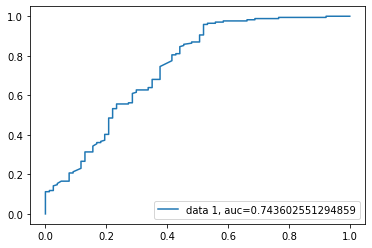

In [547]:
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [548]:
from sklearn import metrics
preds = model.predict_proba(X_test)
tpr, tpr, thresholds = roc_curve(y_test,preds[:,1])
print (thresholds)

accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(preds[:,1]>thres,1,0)
    # Apply desired utility function to y_preds, for example accuracy.
    accuracy_ls.append(f1_score(y_test, y_pred))

[1.93190744 0.93190744 0.92645004 0.9014124  0.90013223 0.89631016
 0.89627502 0.89509624 0.89017402 0.88939053 0.88880226 0.88036338
 0.87328659 0.86592963 0.86375628 0.86131024 0.85607873 0.8511863
 0.84111841 0.84042269 0.83197882 0.82460643 0.81550516 0.80864615
 0.8062256  0.80031224 0.79502765 0.7940013  0.78828531 0.78762467
 0.78724779 0.78079832 0.77288318 0.76470605 0.76116254 0.75975589
 0.75908228 0.75217706 0.75198294 0.7478326  0.74011291 0.73774104
 0.7375966  0.72981323 0.7294824  0.70865778 0.70625173 0.70529277
 0.70528894 0.70022335 0.69650987 0.69055183 0.68824314 0.68502397
 0.67366274 0.66856157 0.65927662 0.65780038 0.6567111  0.6335425
 0.60921427 0.60567916 0.59280963 0.58110954 0.46053954 0.4458831
 0.44374599 0.37059608 0.31534476 0.29494646 0.23960717 0.2211276
 0.20983821 0.2083958  0.20445883 0.17228908 0.15314044 0.11127209
 0.10933926 0.05898867]


In [549]:
joblib.dump(model,r"../models/1_base_model.sav")

['../models/1_base_model.sav']

In [33]:
random_forest_pipe = Pipeline(steps=[
    ('preprocess',preprocessing),
    ('model',RandomForestClassifier())
],verbose=True)



In [34]:
params= {
    "model__n_estimators" : [20,50,100,150],
    "model__max_depth" : [2,3,5,6],
}

In [35]:
model_forest = GridSearchCV(random_forest_pipe,param_grid=params,cv=4)

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=df['Loan_Status'],random_state=60,train_size=0.6)

In [37]:
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

In [38]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [39]:
params = {}

In [40]:
model_forest.fit(X_train,y_train)

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('impute',
                                                         Pipeline(steps=[('transformations',
                                                                          FunctionTransformer(func=<function transform_dataset at 0x0000018772B80B80>)),
                                                                         ('feature_union',
                                                                          FeatureUnion(transformer_list=[('cat_pipe',
                                                                                                          Pipeline(steps=[('cat',
                                                                                                                           ColumnTransformer(transformers=[('employed',
                                                                                                           

In [41]:
f1_score(y_train,model_forest.predict(X_train))

0.8687943262411347

In [42]:
model_forest.best_estimator_

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('impute',
                                  Pipeline(steps=[('transformations',
                                                   FunctionTransformer(func=<function transform_dataset at 0x0000018772B80B80>)),
                                                  ('feature_union',
                                                   FeatureUnion(transformer_list=[('cat_pipe',
                                                                                   Pipeline(steps=[('cat',
                                                                                                    ColumnTransformer(transformers=[('employed',
                                                                                                                                     PipeCustomOrdinalEncoder(),
                                                                                                                                     'Self_Employed')

In [43]:
f1_score(y_test,model_forest.predict(X_test))

0.8723404255319148

In [44]:
recall_score(y_test,model_forest.predict(X_test))

0.9822485207100592

In [45]:
recall_score(y_train,model_forest.predict(X_train))

0.9683794466403162

In [68]:
print(confusion_matrix(y_test,model_forest.predict(X_test)))

NameError: name 'model_forest' is not defined

In [50]:
import xgboost as xgb

In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=df['Loan_Status'],random_state=60,train_size=0.6)
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [54]:
params= {
    "model__n_estimators" : [20,50,100,150],
    "model__max_depth" : [2,3,5,6],
}

In [59]:
xgb_pipe = Pipeline(steps=[
    ('preprocess',preprocessing),
    ('model',xgb.XGBClassifier())
],verbose=True)

model_xgb = GridSearchCV(xgb_pipe,param_grid=params,cv=4)

In [61]:
model_xgb.fit(X_train,y_train)

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(lab

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[11:03:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(lab

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._se

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = g


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(lab

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._se

[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(lab


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._se

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = g


[11:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = g


[11:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a cop

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._se

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = g

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(lab

[11:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a cop


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(lab


[11:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a cop


[11:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._se


[11:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = g

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = g

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a cop

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._se

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = g


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(lab

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._se


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._se

[11:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[11:03:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(lab


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a cop

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(lab


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a cop


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a cop

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 


[11:03:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = g

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a cop

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._se

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = g

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda\envs\geo_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
[11:03:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('impute',
                                                         Pipeline(steps=[('transformations',
                                                                          FunctionTransformer(func=<function transform_dataset at 0x0000018772B80B80>)),
                                                                         ('feature_union',
                                                                          FeatureUnion(transformer_list=[('cat_pipe',
                                                                                                          Pipeline(steps=[('cat',
                                                                                                                           ColumnTransformer(transformers=[('employed',
                                                                                                           

In [62]:
f1_score(y_test,model_xgb.predict(X_test))

0.8639999999999999

In [63]:
f1_score(y_train,model_xgb.predict(X_train))

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.8716094032549728

In [65]:
recall_score(y_test,model_xgb.predict(X_test))

0.9408284023668639

In [66]:
recall_score(y_train,model_xgb.predict(X_train))

0.932806324110672

In [67]:
print(confusion_matrix(y_test,model_xgb.predict(X_test)))

NameError: name 'model_xgb' is not defined